In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from utils import get_data_path, get_data, get_avg, low_pass_filter, fit_lorentzian, replace_peak

In [67]:
root_path = Path('/Users/jack/Documents/lipid/')

In [69]:
def load_series(I_list, metadata):
    for path in get_data_path(metadata, root_path):
        try:
            I_list.append((get_data(path)[0], get_data(path)[3]))
            print("Loaded data from", path)
        except Exception as e:
            print(f"Error loading data from path {path}: {e}")

In [70]:
I_trans_list = []
load_series(I_trans_list, azo_trans_metadata)
I_cis_list = []
load_series(I_cis_list, azo_cis_metadata)
I_cis_2_list = []
load_series(I_cis_2_list, azo_cis_2_metadata)
I_cis_3_list = []
load_series(I_cis_3_list, azo_cis_3_metadata)

Loaded data from /Users/jack/Documents/lipid/azo_trans/54
Loaded data from /Users/jack/Documents/lipid/azo_trans/58
Loaded data from /Users/jack/Documents/lipid/azo_trans/62
Loaded data from /Users/jack/Documents/lipid/azo_cis/78
Loaded data from /Users/jack/Documents/lipid/azo_cis/82
Loaded data from /Users/jack/Documents/lipid/azo_cis/86
Loaded data from /Users/jack/Documents/lipid/azo_cis/90
Loaded data from /Users/jack/Documents/lipid/azo_cis_2/106
Loaded data from /Users/jack/Documents/lipid/azo_cis_2/110
Loaded data from /Users/jack/Documents/lipid/azo_cis_3/115
Loaded data from /Users/jack/Documents/lipid/azo_cis_3/119


In [71]:
water_metadata = metadata[(metadata['method']=='GIXD') & (metadata['sample']=='water')]
I_water, Q_xy, Q_z, _ = get_data(get_data_path(water_metadata, root_path)[0])
Q_xy, Q_z = np.meshgrid(Q_xy, Q_z)
extent = [Q_xy[0,0], Q_xy[-1,-1], Q_z[0,0], Q_z[-1,-1]]
print("Q_xy from", Q_xy[0,0], "to", Q_xy[-1,-1])
print("Q_z from", Q_z[0,0], "to", Q_z[-1,-1])

Q_xy from 0.655 to 1.8575
Q_z from -0.0175 to 1.34


In [72]:
I_trans_subtracted_list = [(I_trans[0] - I_water, I_trans[1]) for I_trans in I_trans_list]
I_cis_subtracted_list = [(I_cis[0] - I_water, I_cis[1]) for I_cis in I_cis_list]
I_cis_2_subtracted_list = [(I_cis_2[0] - I_water, I_cis_2[1]) for I_cis_2 in I_cis_2_list]
I_cis_3_subtracted_list = [(I_cis_3[0] - I_water, I_cis_3[1]) for I_cis_3 in I_cis_3_list]

In [73]:
def plot_series(I_list, extent, sample_name, figsize=None):
    fig = plt.figure(figsize=figsize)
    for i, I in enumerate(I_list):
        pressure = metadata[metadata['scan_id']==int(I[1])]['pressure_mN/m'].values[0]
        ax = fig.add_subplot(1, len(I_list), i + 1)
        ax.imshow(I[0], cmap='hot', extent=extent, origin='lower', vmin=5, vmax=15)
        ax.set_title(f'{sample_name}\n{pressure} mN/m, scan {I[1]}')
        ax.set_xticks([0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
    plt.savefig(f'imshow_{sample_name}.png', dpi=100)
    plt.show()

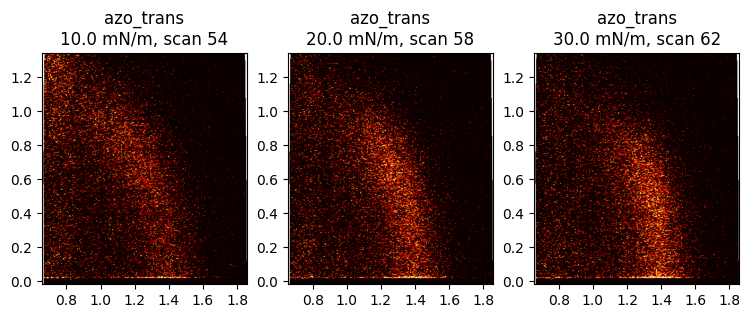

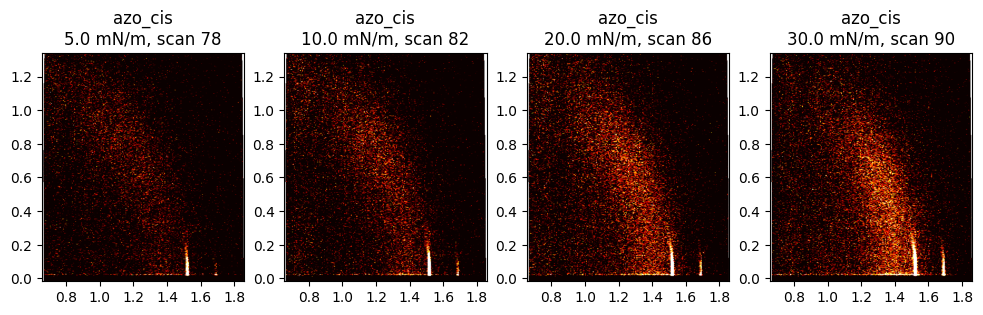

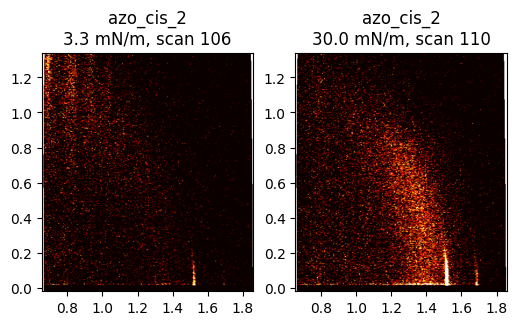

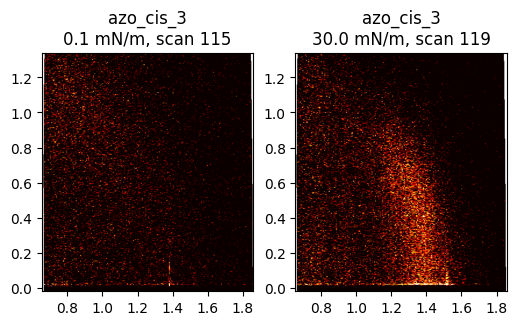

In [74]:
plot_series(I_trans_subtracted_list, extent, 'azo_trans', (9, 6))
plot_series(I_cis_subtracted_list, extent, 'azo_cis', (12, 6))
plot_series(I_cis_2_subtracted_list, extent, 'azo_cis_2', (6, 6))
plot_series(I_cis_3_subtracted_list, extent, 'azo_cis_3', (6, 6))

/Users/jack/workspace/own/lipid-gixd-gixos/utils.py:50: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(crop, axis=0)


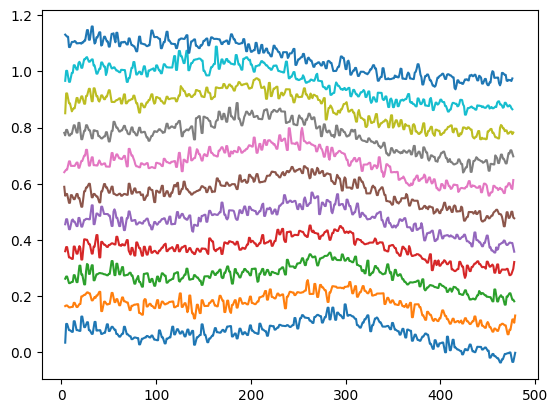

In [75]:
step = 0.1
n_steps = int(1.2 / step)
roi_list = [
    (None, None, step * i, step * (i+1)) for i in range(n_steps)
]
avg_list = [
    get_avg(roi, I_trans_subtracted_list[0][0], Q_xy, Q_z) for roi in roi_list
]
offset = 0
for avg in avg_list:
    plt.plot(avg/40 + offset)
    offset += 0.1
plt.show()

In [76]:
roi = (1, 1.8, 0, 0.25)
trans_avg_list = [
    get_avg(roi, I_trans_subtracted[0], Q_xy, Q_z) for I_trans_subtracted in I_trans_subtracted_list
]
cis_avg_list = [
    get_avg(roi, I_cis_subtracted[0], Q_xy, Q_z) for I_cis_subtracted in I_cis_subtracted_list
]
cis_2_avg_list = [
    get_avg(roi, I_cis_2_subtracted[0], Q_xy, Q_z) for I_cis_2_subtracted in I_cis_2_subtracted_list
]
cis_3_avg_list = [
    get_avg(roi, I_cis_3_subtracted[0], Q_xy, Q_z) for I_cis_3_subtracted in I_cis_3_subtracted_list
]   
trans_avg_list = [low_pass_filter(trans_avg) for trans_avg in trans_avg_list]
cis_avg_list = [low_pass_filter(cis_avg) for cis_avg in cis_avg_list]
cis_2_avg_list = [low_pass_filter(cis_2_avg) for cis_2_avg in cis_2_avg_list]
cis_3_avg_list = [low_pass_filter(cis_3_avg) for cis_3_avg in cis_3_avg_list]

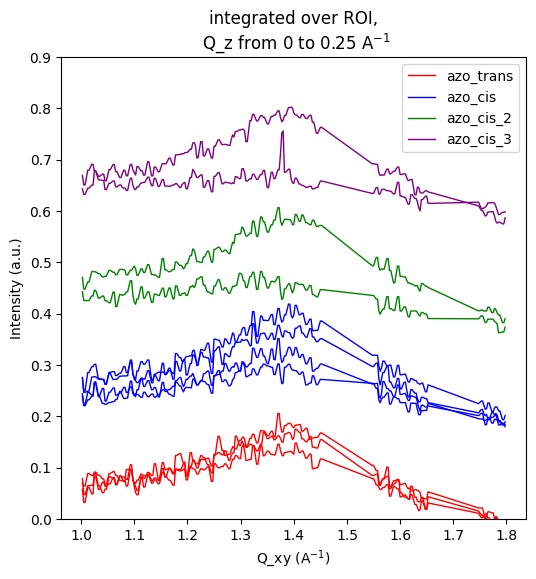

In [77]:
fig = plt.figure(figsize=(6, 6))
offset_step = 0
offset = 0
Q_xy_range_list = [(1.45, 1.55), (1.65, 1.75)]
for trans_avg in trans_avg_list:
    trans_avg = replace_peak(trans_avg, Q_xy, Q_xy_range_list)
    line_trans, = plt.plot(Q_xy[0], trans_avg/40 + offset, color='red', linewidth=1)
    offset += offset_step
offset = 0.2
for cis_avg in cis_avg_list:
    cis_avg = replace_peak(cis_avg, Q_xy, Q_xy_range_list)
    line_cis, = plt.plot(Q_xy[0], cis_avg/40 + offset, color='blue', linewidth=1)
    offset += offset_step
offset = 0.4
for cis_2_avg in cis_2_avg_list:
    cis_2_avg = replace_peak(cis_2_avg, Q_xy, Q_xy_range_list)
    line_cis_2, = plt.plot(Q_xy[0], cis_2_avg/40 + offset, color='green', linewidth=1)
    offset += offset_step
offset = 0.6
for cis_3_avg in cis_3_avg_list:
    cis_3_avg = replace_peak(cis_3_avg, Q_xy, Q_xy_range_list)
    line_cis_3, = plt.plot(Q_xy[0], cis_3_avg/40 + offset, color='purple', linewidth=1)
    offset += offset_step
plt.legend([line_trans, line_cis, line_cis_2, line_cis_3], ['azo_trans', 'azo_cis', 'azo_cis_2', 'azo_cis_3'])
plt.ylim(0, 0.9)
plt.xlabel('Q_xy (A$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title(f"integrated over ROI,\n Q_z from {roi[2]} to {roi[3]}"+" A$^{-1}$")
plt.savefig('plot_all.png', dpi=100)
plt.show()

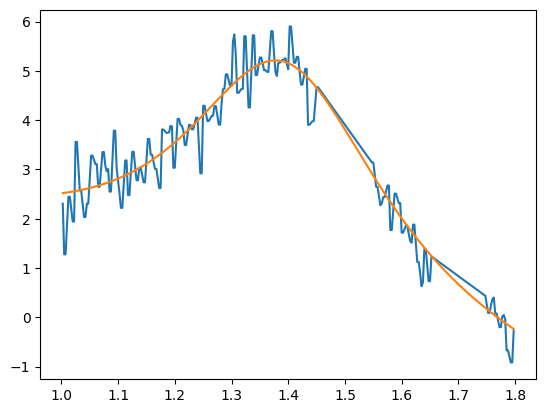

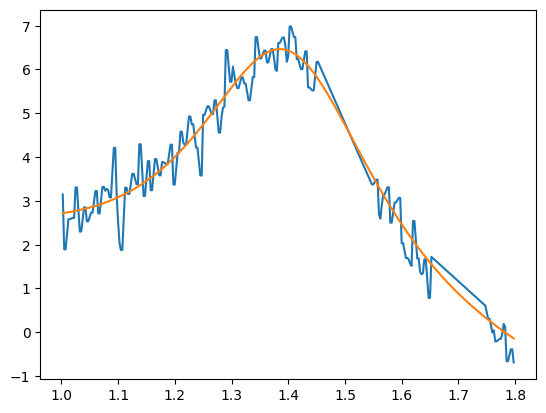

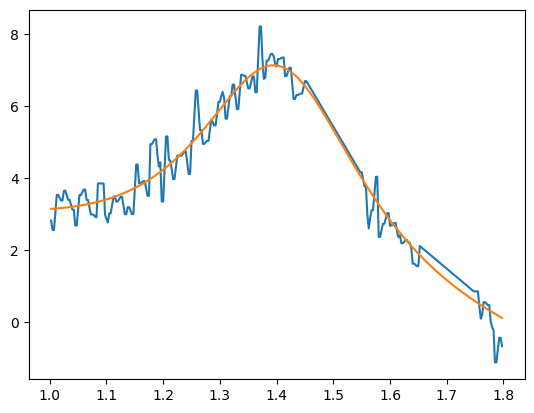

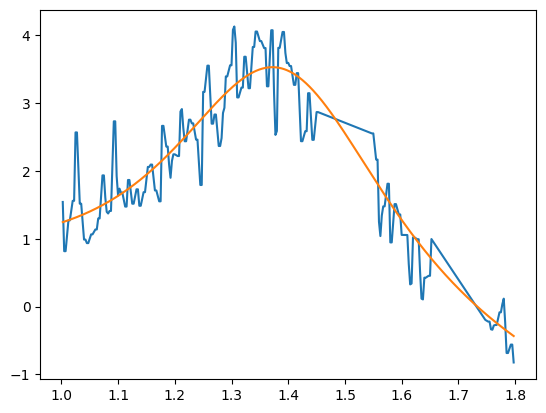

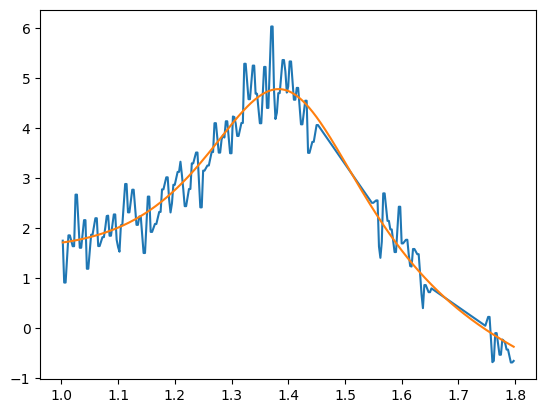

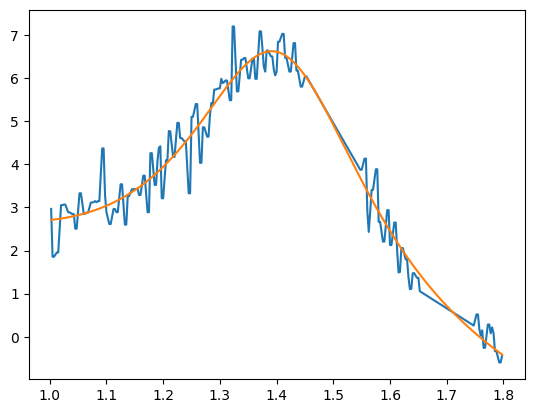

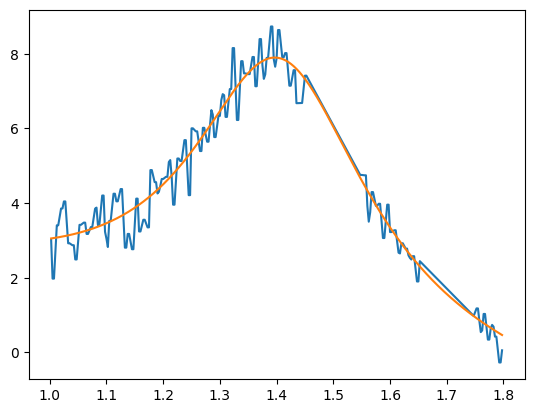

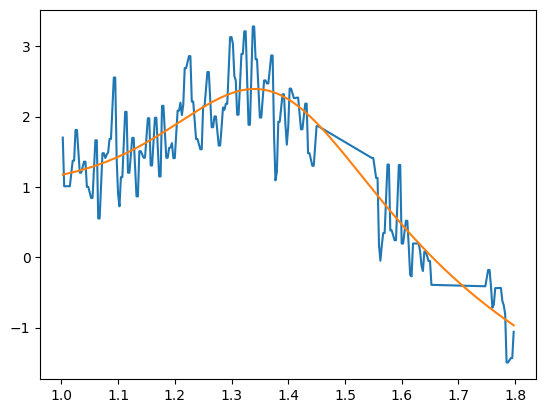

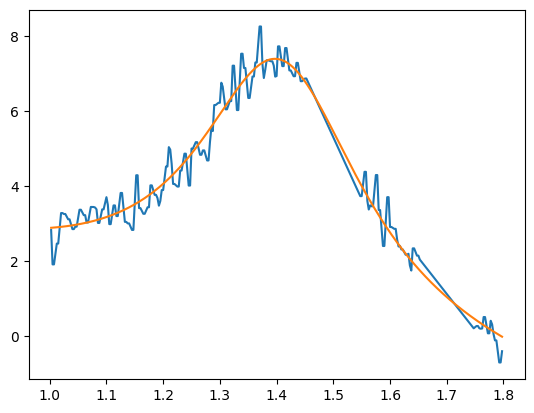

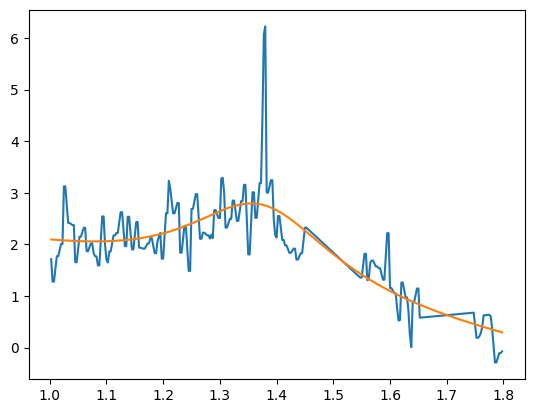

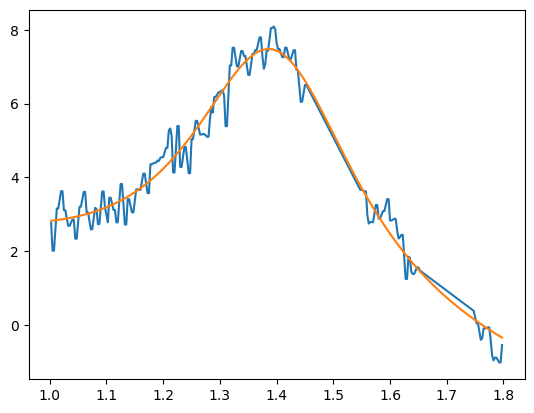

(np.float64(1.3928271655396085), np.float64(0.002081826873341617), 'trans')
(np.float64(1.3964157197977733), np.float64(0.0015395025067104194), 'trans')
(np.float64(1.4044694602111103), np.float64(0.0014334709058245502), 'trans')
(np.float64(1.3864472306386382), np.float64(0.0030696104225711274), 'cis')
(np.float64(1.3926537141513784), np.float64(0.0017431124159459023), 'cis')
(np.float64(1.4028957471775387), np.float64(0.0014251219802433965), 'cis')
(np.float64(1.4046562610481619), np.float64(0.0013180298783134648), 'cis')
(np.float64(1.3697205715750134), np.float64(0.0051152017903723585), 'cis_2')
(np.float64(1.4053800987804848), np.float64(0.001084966568923177), 'cis_2')
(np.float64(1.371437712414838), np.float64(0.005371729652439069), 'cis_3')
(np.float64(1.3947676517841452), np.float64(0.0011256197655831965), 'cis_3')
(np.float64(0.21884577669352356), np.float64(0.04052439471597881), 'trans')
(np.float64(0.20263730226328389), np.float64(0.031034609774419467), 'trans')
(np.float64(

In [78]:
nan_mask = np.isnan(trans_avg_list[0])
Q_xy_max = []
w_xy = []
for trans_avg in trans_avg_list:
    popt, pcov, Q_xy_fit, I_fit = fit_lorentzian(Q_xy[0][~nan_mask], trans_avg[~nan_mask])
    plt.plot(Q_xy[0][~nan_mask], trans_avg[~nan_mask])
    plt.plot(Q_xy_fit, I_fit)
    plt.show()
    Q_xy_max.append((popt[1], pcov[1][1]**0.5/popt[1], 'trans'))
    w_xy.append((popt[2], pcov[2][2]**0.5/popt[2], 'trans'))

for cis_avg in cis_avg_list:
    popt, pcov, Q_xy_fit, I_fit = fit_lorentzian(Q_xy[0][~nan_mask], cis_avg[~nan_mask])
    plt.plot(Q_xy[0][~nan_mask], cis_avg[~nan_mask])
    plt.plot(Q_xy_fit, I_fit)
    plt.show()
    Q_xy_max.append((popt[1], pcov[1][1]**0.5/popt[1], 'cis'))
    w_xy.append((popt[2], pcov[2][2]**0.5/popt[2], 'cis'))

for cis_2_avg in cis_2_avg_list:
    popt, pcov, Q_xy_fit, I_fit = fit_lorentzian(Q_xy[0][~nan_mask], cis_2_avg[~nan_mask])
    plt.plot(Q_xy[0][~nan_mask], cis_2_avg[~nan_mask])
    plt.plot(Q_xy_fit, I_fit)
    plt.show()
    Q_xy_max.append((popt[1], pcov[1][1]**0.5/popt[1], 'cis_2'))
    w_xy.append((popt[2], pcov[2][2]**0.5/popt[2], 'cis_2'))

for cis_3_avg in cis_3_avg_list:
    popt, pcov, Q_xy_fit, I_fit = fit_lorentzian(Q_xy[0][~nan_mask], cis_3_avg[~nan_mask])
    plt.plot(Q_xy[0][~nan_mask], cis_3_avg[~nan_mask])
    plt.plot(Q_xy_fit, I_fit)
    plt.show()
    Q_xy_max.append((popt[1], pcov[1][1]**0.5/popt[1], 'cis_3'))
    w_xy.append((popt[2], pcov[2][2]**0.5/popt[2], 'cis_3'))

for item in Q_xy_max:
    print(item)

for item in w_xy:
    print(item)